In [18]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("AirQualityUCI.csv")
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [4]:
# Rename the columns to be more descriptive
data.rename(columns={
    'Date': 'Measurement_Date',
    'Time': 'Measurement_Time',
    'CO(GT)': 'Carbon_Monoxide_Concentration',
    'PT08.S1(CO)': 'CO_Sensor_Measurement',
    'NMHC(GT)': 'Non_Methane_Hydrocarbons_Concentration',
    'C6H6(GT)': 'Benzene_Concentration',
    'PT08.S2(NMHC)': 'NMHC_Sensor_Measurement',
    'NOx(GT)': 'Nitrogen_Oxides_Concentration',
    'PT08.S3(NOx)': 'NOx_Sensor_Measurement',
    'NO2(GT)': 'Nitrogen_Dioxide_Concentration',
    'T': 'Temperature_Celsius',
    'RH': 'Relative_Humidity',
    'AH': 'Absolute_Humidity'
}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Measurement_Date                        9357 non-null   object 
 1   Measurement_Time                        9357 non-null   object 
 2   Carbon_Monoxide_Concentration           9357 non-null   float64
 3   CO_Sensor_Measurement                   9357 non-null   float64
 4   Non_Methane_Hydrocarbons_Concentration  9357 non-null   float64
 5   Benzene_Concentration                   9357 non-null   float64
 6   NMHC_Sensor_Measurement                 9357 non-null   float64
 7   Nitrogen_Oxides_Concentration           9357 non-null   float64
 8   NOx_Sensor_Measurement                  9357 non-null   float64
 9   Nitrogen_Dioxide_Concentration          9357 non-null   float64
 10  PT08.S4(NO2)                            9357 non-null   floa

In [5]:
# Remove empty last two columns
data.drop(data.columns[15:17], axis=1, inplace=True)

# After visual inspection, it looks like there are only 9358 entries in the csv file. Not sure why data.info() is registering 9471 
# data entries? Because of this, I will only "keep" the 9358 rows.
data = data[:9358]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9358 entries, 0 to 9357
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Measurement_Date                        9357 non-null   object 
 1   Measurement_Time                        9357 non-null   object 
 2   Carbon_Monoxide_Concentration           9357 non-null   float64
 3   CO_Sensor_Measurement                   9357 non-null   float64
 4   Non_Methane_Hydrocarbons_Concentration  9357 non-null   float64
 5   Benzene_Concentration                   9357 non-null   float64
 6   NMHC_Sensor_Measurement                 9357 non-null   float64
 7   Nitrogen_Oxides_Concentration           9357 non-null   float64
 8   NOx_Sensor_Measurement                  9357 non-null   float64
 9   Nitrogen_Dioxide_Concentration          9357 non-null   float64
 10  PT08.S4(NO2)                            9357 non-null   floa

In [6]:
# Isolate the numerical data columns
numerical_data = data.iloc[:, 2:15]

# The dataset notes that some measurements may be recorded as -200, indicating missing or invalid data points. I will remove 
# any -200 values and replace them with the mean value in the column.
numerical_data.replace(-200, pd.NA, inplace=True)

# Replace NaN values with the median of each column
numerical_data.fillna(numerical_data.mean(), inplace=True)

/tmp/ipykernel_123037/1060368509.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numerical_data.fillna(numerical_data.mean(), inplace=True)


In [9]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(GRUModel, self).__init__()
        self.model_type = "GRU"  # Model type string
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # The GRU layer processes input sequences and produces outputs and hidden states for each time step.
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        # A fully connected (linear) layer that maps the output of the GRU to the desired output size.
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # initialize hidden state
        out, _ = self.gru(x, h0)  # GRU layer
        out = self.fc(out[:, -1, :])  # Take only the last time step's output
        return out

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(LSTMModel, self).__init__()
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        
        # Fully connected layer to map from hidden_size to output_size (3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass through the LSTM layer
        lstm_out, (hn, cn) = self.lstm(x)
        
        # Take the last time step output
        out = self.fc(lstm_out[:, -1, :])
        
        return out

In [30]:
# Scale the data using the MinMaxScaler and save it for inverse-tranforms
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numerical_data)
joblib.dump(scaler, "scaler.pkl")

# The time series data that will be predicted is the Nitrogen Dioxide Concentration
scaled_df = pd.DataFrame(scaled_data, columns=numerical_data.columns)
all_features = scaled_df.loc[:, scaled_df.columns != 'Nitrogen_Dioxide_Concentration'].to_numpy()
target_data = scaled_df['Nitrogen_Dioxide_Concentration'].to_numpy()

# Create the input sequences and targets. The target will be the 13th value after a sequence of 12.
sequence_length = 12  
X, y = [], []
for i in range(len(all_features) - sequence_length):
    X.append(all_features[i:i + sequence_length])
    y.append(target_data[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create DataLoaders for training, validation, and testing
dataset = TensorDataset(X, y)
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Sequentially split the dataset
train_dataset = TensorDataset(X[:train_size], y[:train_size])
val_dataset = TensorDataset(X[train_size:train_size+val_size], y[train_size:train_size+val_size])
test_dataset = TensorDataset(X[train_size+val_size:], y[train_size+val_size:])

In [40]:
# Setup hyperparameters
input_size = 12  # Each time step has 12 input features
hidden_size = [16, 24, 32]  # Number of LSTM/GRU hidden units
output_size = 1  # Predicting NO2 concentration
num_layers = [1, 2] #[1, 2, 3] # Number of layers in the LSTM/GRU
learning_rate = 0.001
num_epochs = 75
dropout = 0.4
weight_decay = 0.01  # L2 regularization strength
batch_size = [4, 6, 8] #[4, 8, 12]
criterion = nn.MSELoss()
patience = 8  # Number of epochs with no improvement to wait before stopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
best_val_loss = float('inf')

# Iterate through the hyperparameter space
for hidden in hidden_size:
    for batch in batch_size:
        for layer in num_layers:
            
            # Create data loaders for each subset with drop_last for maintaining consistent batch shapes
            train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, drop_last=True)
            val_loader = DataLoader(val_dataset, batch_size=batch, drop_last=True)
            
            # Instantiate models
            gru_model = GRUModel(input_size, hidden, output_size, layer, dropout)
            lstm_model = LSTMModel(input_size, hidden, output_size, layer, dropout)
            models = [gru_model, lstm_model]
                       
            for model in models:
                optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
                
                # Instantiate the scheduler (reduce LR when validation loss has stopped improving)
                scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
                epochs_since_improvement = 0
                training_losses = []
                validation_losses = []
                
                for epoch in range(num_epochs):
                    train_loss = 0
                    
                    model.train()  # Ensure the model is in training mode
                    for X_batch, y_batch in train_loader:
                        X_batch = X_batch.view(-1, sequence_length, input_size)
                        outputs = model(X_batch)
                        y_batch = y_batch.view(-1, output_size)
                        
                        loss = criterion(outputs, y_batch)
                        train_loss += loss.item()
                        
                        optimizer.zero_grad()
                        loss.backward()
                        # Add gradient clipping to prevent exploding gradients
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()

                    avg_train_loss = train_loss / len(train_loader)
                    training_losses.append(avg_train_loss)
                    
                    # Validation step
                    model.eval()  # Switch to evaluation mode
                    val_loss = 0.0
                    with torch.no_grad():
                        for X_batch, y_batch in val_loader:
                            X_batch = X_batch.view(-1, sequence_length, input_size)
                            val_outputs = model(X_batch)
                            y_batch = y_batch.view(-1, output_size)
                            val_loss += criterion(val_outputs, y_batch).item()

                    # Average the validation loss over batches
                    val_loss /= len(val_loader)  
                    validation_losses.append(val_loss)
                    
                    # Step the scheduler based on the validation loss
                    scheduler.step(val_loss)
                    
                    # Check if the validation loss has improved
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        epochs_since_improvement = 0
                        model_path = f'best_model_{model.__class__.__name__}_hidden{hidden}_layers{layer}_batch{batch}.pth'
                        torch.save(model.state_dict(), model_path)
                        print(f'Best model: {model.__class__.__name__} saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}, '
                              f'hidden size: {hidden}, num layers: {layer}, batch size: {batch}')

                        # Save training and validation losses
                        best_train_losses = training_losses.copy()
                        best_val_losses = validation_losses.copy()
                        
                    else:
                        epochs_since_improvement += 1

                    # If 5 epochs have passed without improvement after the first 40 epochs, the training stops for this model with the
                    # current hyperparameters
                    if epoch > 40 and epochs_since_improvement >= patience:
                        break

/home/abey/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Best model: GRUModel saved at epoch 1 with validation loss: 0.0113, hidden size: 16, num layers: 1, batch size: 4
Best model: GRUModel saved at epoch 2 with validation loss: 0.0070, hidden size: 16, num layers: 1, batch size: 4
Best model: GRUModel saved at epoch 4 with validation loss: 0.0070, hidden size: 16, num layers: 1, batch size: 4


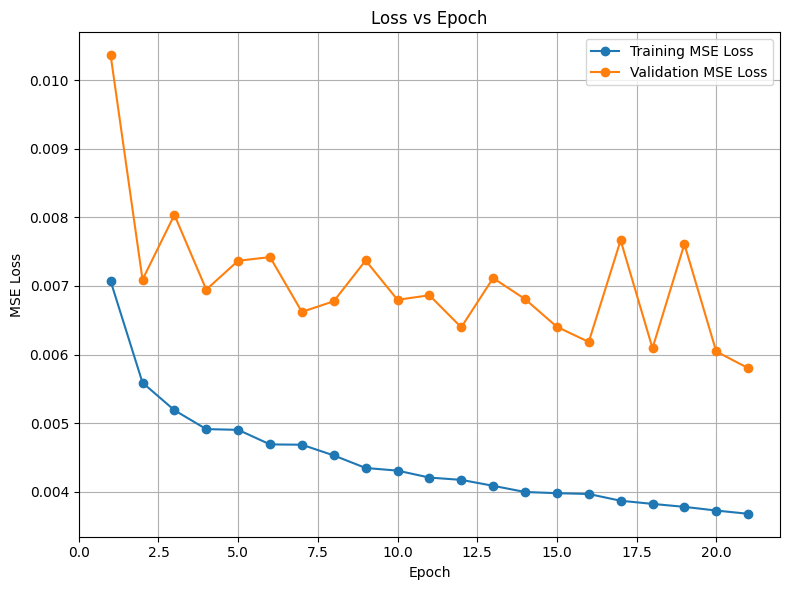

In [33]:
# Plot the loss and F1 score vs training epoch
epochs = range(1, len(best_train_losses) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, best_train_losses, label='Training MSE Loss', marker='o')
plt.plot(epochs, best_val_losses, label='Validation MSE Loss', marker='o')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Evaluate on test data with the best performing model from training/validation
# Best model: GRUModel saved at epoch 21 with validation loss: 0.0058, hidden size: 32, num layers: 2, batch size: 8
model = GRUModel(input_size=12, hidden_size=32, output_size=1, num_layers=2)
model.load_state_dict(torch.load('best_model_GRUModel_hidden32_layers2_batch8.pth', weights_only=True))
model.eval()
test_loss = 0
all_outputs = []
all_targets = []

test_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.view(-1, sequence_length, input_size)
        
        outputs = model(X_batch)
        y_batch = y_batch.view(-1, output_size)  # Adjust to the correct shape

        all_outputs.append(outputs.numpy())
        all_targets.append(y_batch.view(-1, output_size).numpy())
        
        # Accumulate the batch loss
        test_loss += criterion(outputs, y_batch).item()
        
test_loss /= len(test_loader)

# Concatenate all outputs and targets
all_outputs = np.concatenate(all_outputs, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Use the scaler to transform the predictions/targets into their original distribution for metrics calculations
scaler = joblib.load("scaler.pkl")
feature_names = numerical_data.columns.tolist()
target_idx = feature_names.index('Nitrogen_Dioxide_Concentration')

# Create dummy array with zeros, then insert predictions into the correct column
expanded_outputs = np.zeros((all_outputs.shape[0], len(feature_names)))
expanded_outputs[:, target_idx] = all_outputs.squeeze()  # squeeze in case shape is (n, 1)
expanded_targets = np.zeros((all_targets.shape[0], len(feature_names)))
expanded_targets[:, target_idx] = all_targets.squeeze()
inverse_targets = scaler.inverse_transform(expanded_targets)[:, target_idx]

# Apply inverse transform
inverse_preds = scaler.inverse_transform(expanded_outputs)[:, target_idx]

# Compute additional metrics
mae = mean_absolute_error(inverse_targets, inverse_preds)
r2 = r2_score(inverse_targets, inverse_preds)

print(f'Test Loss (MSE): {test_loss:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R^2): {r2:.4f}')

Test Loss (MSE): 0.0120
Mean Absolute Error (MAE): 27.7057
R-squared (R^2): 0.4958


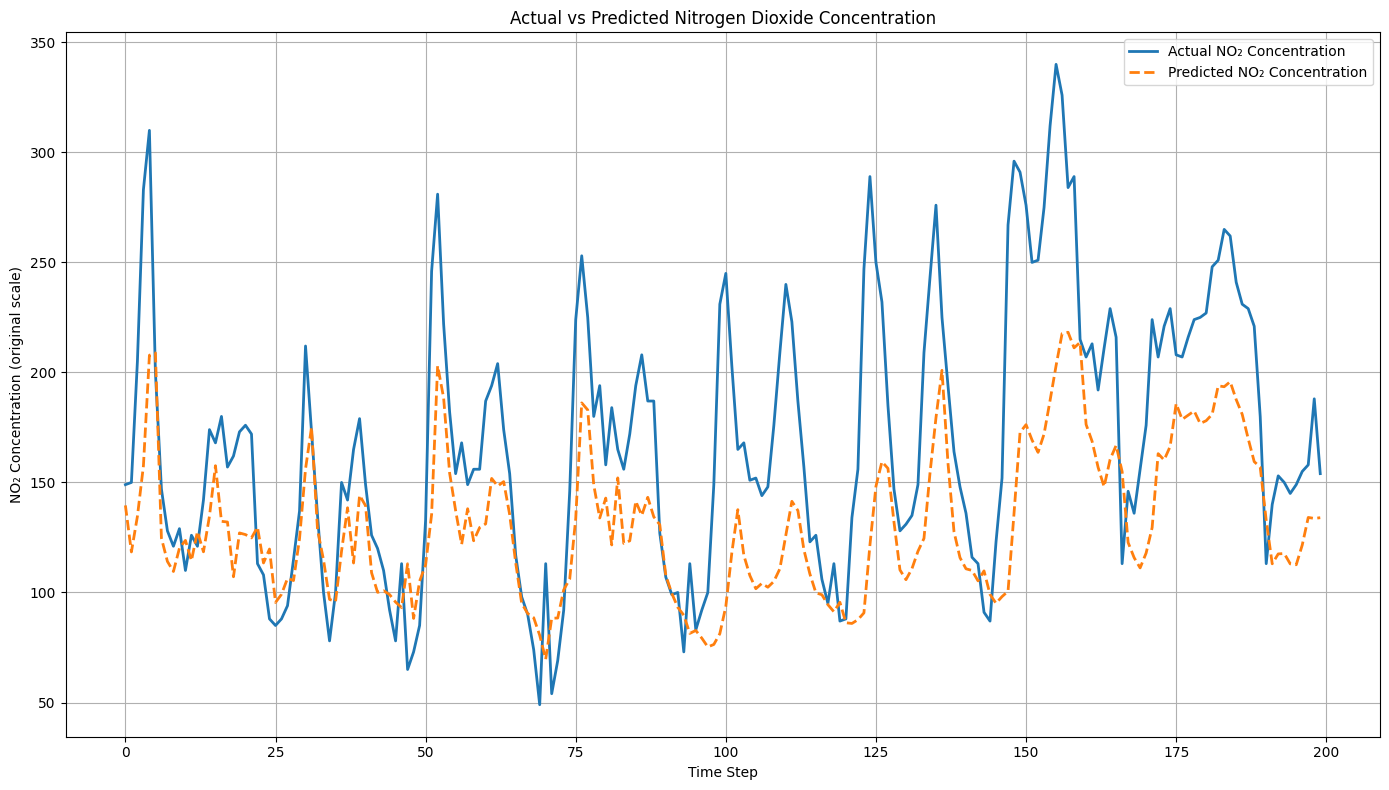

In [38]:
# Number of test points to plot
n_plot = 200

plt.figure(figsize=(14, 8))
plt.plot(inverse_targets[:n_plot], label='Actual NO₂ Concentration', linewidth=2)
plt.plot(inverse_preds[:n_plot], label='Predicted NO₂ Concentration', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Nitrogen Dioxide Concentration')
plt.xlabel('Time Step')
plt.ylabel('NO₂ Concentration (original scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()